# 4_metrics_nucleus_celltype_diversity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from thalamus_merfish_analysis import ccf_plots as cplot
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_registration as ccf
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_erode as cerd
from thalamus_merfish_analysis import diversity_metrics as divmet
from thalamus_merfish_analysis import diversity_plots as divplot

get_ipython().run_line_magic('matplotlib', 'inline') 

## Load ABC Thalamus dataset

In [3]:
# load just the obs
obs = abc.load_standard_thalamus(data_structure='obs')

In [4]:
# load CCF image volumes
realigned=False
ccf_images = abc.get_ccf_labels_image(resampled=True, realigned=realigned)

In [5]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'
x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

## Define eroded CCF regions

In [6]:
obs = cerd.label_cells_by_eroded_ccf(obs, ccf_images) # default is erosion by 5px (5um)

In [7]:
# There is poor alignment in section 6.6 between PF celltypes and the PF CCF structure
# So, we'll set all cells in section 6.6 to 'unassigned' CCF structure
obs.loc[lambda df: df['z_section']==6.6, cerd.ERODED_CCF_STRUCTURE_COL] = 'unassigned'

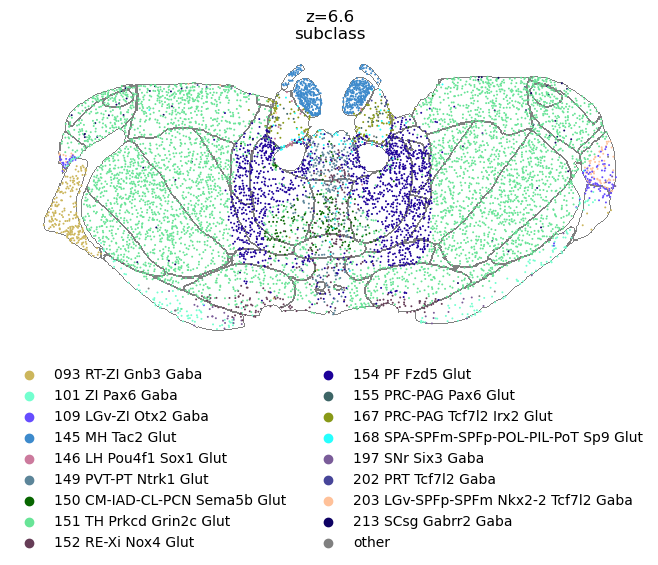

In [8]:
# We can visualize this mismatch (see `154 PF Fzd5 Glut` subclass in dark blue) 
# by using our plotting functions from the `2_view_thalamus_celltypes_ccf` notebook
taxonomy_level = ['subclass']#, 'supertype']
for level in taxonomy_level:
    sec66_fig = cplot.plot_ccf_overlay(obs, ccf_images, 
                                        point_hue=level, 
                                        sections=[6.6],
                                        point_palette=abc.get_taxonomy_palette(level),
                                        legend='cells',
                                        section_col=section_col,
                                        x_col=x_col, 
                                        y_col=y_col,)

## Calculate default set of metrics

In [9]:
ccf_label='parcellation_structure_eroded'
th_ccf_metrics = divmet.calculate_diversity_metrics(obs, ccf_label=ccf_label)
th_ccf_metrics

,count_cluster,count_supertype,count_subclass,frac_cluster,frac_supertype,frac_subclass,count_norm2cells_cluster,count_norm2cells_supertype,count_norm2cells_subclass,count_gt5_cluster,...,frac_gt5_cluster,frac_gt5_supertype,frac_gt5_subclass,inverse_simpsons_cluster,inverse_simpsons_supertype,inverse_simpsons_subclass,shannon_index_cluster,shannon_index_supertype,shannon_index_subclass,count_cells
parcellation_structure_eroded,,,,,,,,,,,,,,,,,,,,,
AD,4,3,3,0.007105,0.018405,0.051724,0.005988,0.004491,0.004491,2,...,0.003552,0.006135,0.017241,1.632833,1.009031,1.009031,0.864324,0.045613,0.045613,668
AM,32,18,8,0.056838,0.110429,0.137931,0.047478,0.026706,0.011869,7,...,0.012433,0.042945,0.051724,4.577734,1.610954,1.185462,2.772185,1.396615,0.560040,674
AV,17,8,3,0.030195,0.049080,0.051724,0.016618,0.007820,0.002933,7,...,0.012433,0.030675,0.034483,2.503736,1.276695,1.261530,1.738747,0.757764,0.529712,1023
CL,37,17,5,0.065719,0.104294,0.086207,0.087678,0.040284,0.011848,14,...,0.024867,0.049080,0.051724,9.256887,5.245479,1.795636,3.906723,2.831493,1.175209,422
CM,33,18,4,0.058615,0.110429,0.068966,0.070968,0.038710,0.008602,21,...,0.037300,0.073620,0.051724,12.364900,6.931844,1.817551,4.179821,3.252881,1.154755,465
Eth,29,14,8,0.051510,0.085890,0.137931,0.161111,0.077778,0.044444,8,...,0.014210,0.030675,0.034483,7.616361,3.246493,1.544622,3.668037,2.399962,1.139193,180
IAD,14,10,3,0.024867,0.061350,0.051724,0.109375,0.078125,0.023438,2,...,0.003552,0.018405,0.034483,2.499085,2.237029,1.713449,1.966762,1.663920,0.973534,128
IAM,17,12,4,0.030195,0.073620,0.068966,0.188889,0.133333,0.044444,5,...,0.008881,0.024540,0.068966,5.314961,3.154206,2.691030,3.068654,2.394282,1.685101,90
IGL,16,9,3,0.028419,0.055215,0.051724,0.500000,0.281250,0.093750,0,...,0.000000,0.006135,0.051724,10.240000,5.171717,2.295964,3.649397,2.710218,1.379004,32


## Plot default metrics

### Select regions to plot

In [10]:
regions_to_plot = divplot.TH_DIVERSITY_REGIONS

### Plot cluster count & frac on dual y-axis barplot

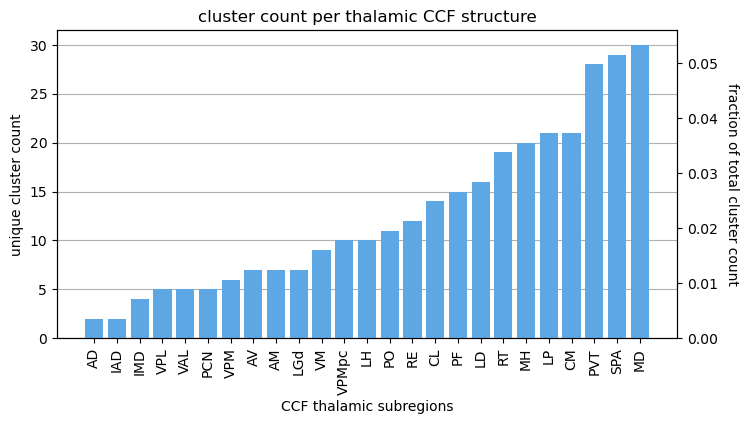

In [12]:
fig = divplot.barplot_dual_y_count_frac(th_ccf_metrics.loc[regions_to_plot], 'cluster', 
                                gt5_only=True)
# fig.savefig("/results/nuclei_cluster_counts_barplot.pdf", transparent=True)

### Plot unique cell type count

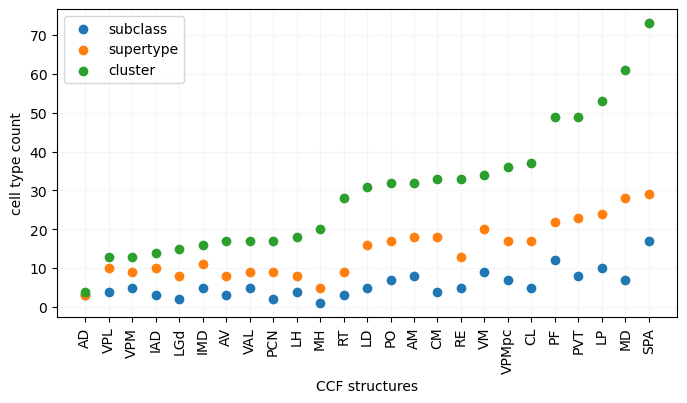

In [13]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count',
                                          ylabel="cell type count")

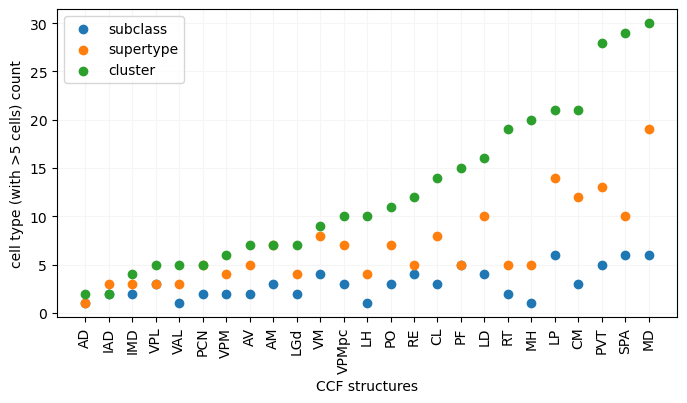

In [14]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_gt5',
                                          ylabel='cell type (with >5 cells) count')

### Plot: cell type count / # cell types

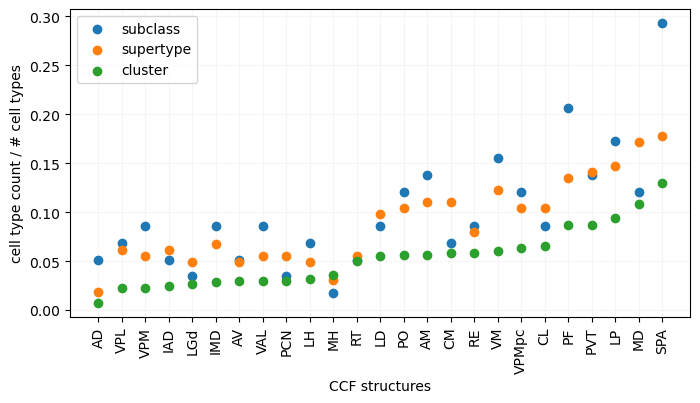

In [15]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac',
                                          ylabel='cell type count / # cell types')

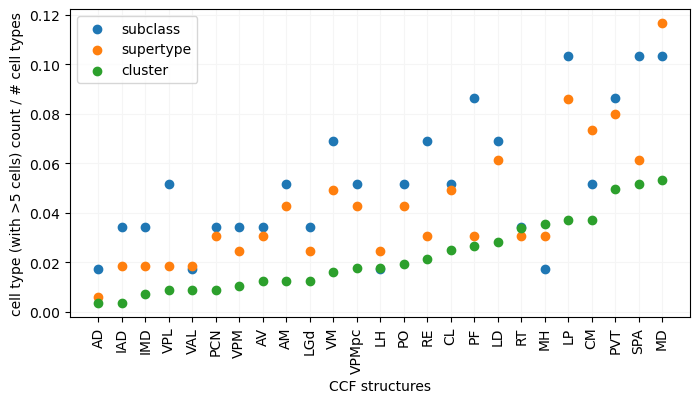

In [16]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'frac_gt5',
                                          ylabel='cell type (with >5 cells) count / # cell types')

### Plot cell type counts, normalized to # of cells in each CCF region

This controls for differing cell densities & region sizes across CCF structures

There is a wide range of sizes (here, we mean # of cells) & cell densities across thalamic CCF structures:

In [17]:
print('thalamic structure with fewest cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmin(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].min())
print('thalamic structure with most cells:\n', 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].idxmax(), 
      th_ccf_metrics.loc[regions_to_plot]['count_cells'].max())


thalamic structure with fewest cells:
 IAD 128
thalamic structure with most cells:
 VPM 3801


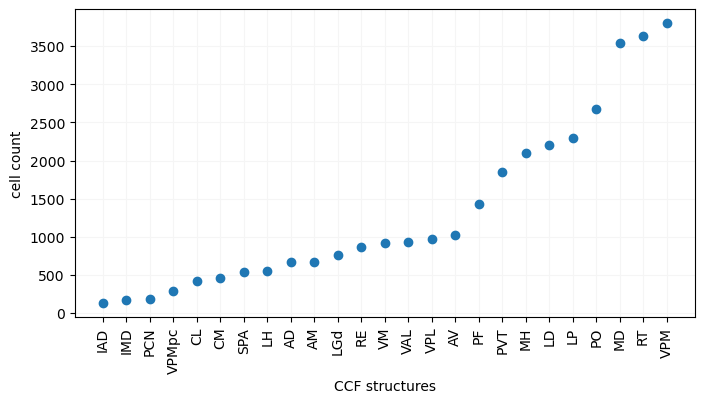

In [18]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_cells', 
                                          levels=None,
                                          ylabel='cell count')

The effect of CCf structure size is weak, but present, and should be accounted for

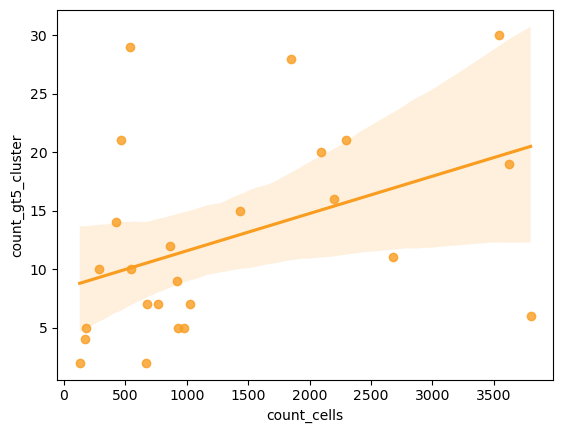

In [19]:
# effect of region size is weak but probably still present...
import seaborn as sns
sns.regplot(th_ccf_metrics.loc[regions_to_plot], x='count_cells', y='count_gt5_cluster', 
            color='#F99D20', label='cluster');

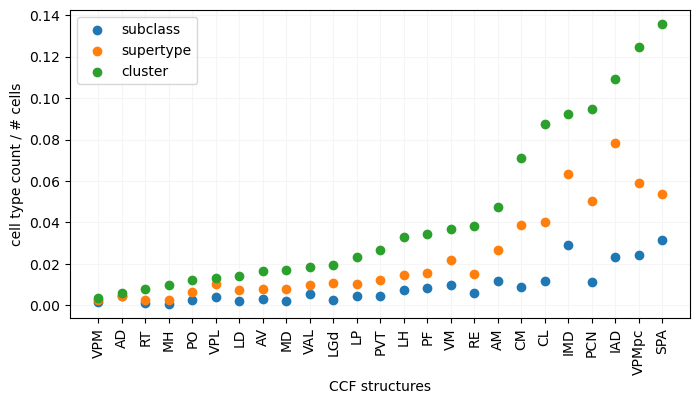

In [20]:
fig = divplot.plot_metric_multiple_levels(th_ccf_metrics.loc[regions_to_plot], 
                                          'count_norm2cells', 
                                          ylabel='cell type count / # cells')

## Display CCF structures shaded by metrics

We have also provided a function in `ccf_plots` that allows you to shade the 
CCF structures by a given metric.

We display 'cluster count / # cells' as a usage example.

In [21]:
# need to load the CCF image volumes
ccf_images = abc.get_ccf_labels_image(resampled=True).astype(int)

# pick the same 3 example sections used in the `2_view_thalamus_celltypes_ccf` notebook
sections_3 = [6.4, 7.2, 8.0] 

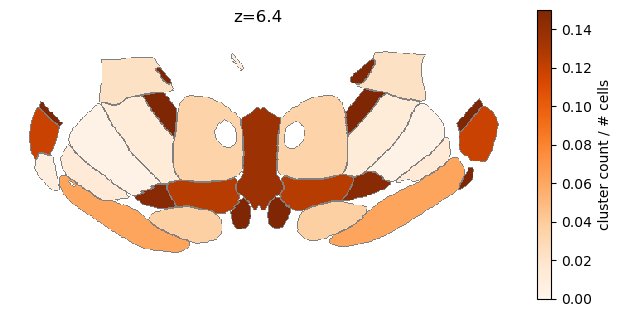

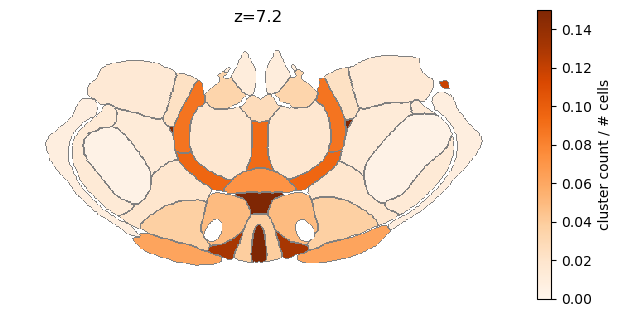

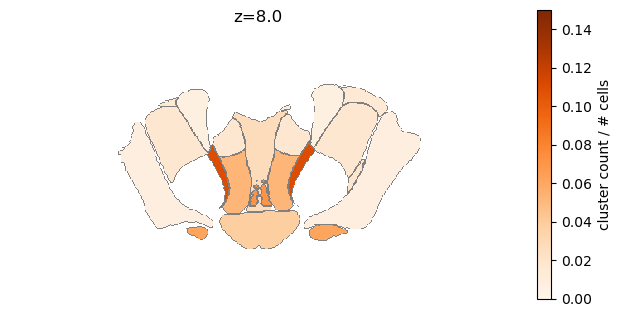

In [22]:
# plot the cell type counts in the CCF structures
figs = cplot.plot_metrics_ccf(ccf_images, 
                              th_ccf_metrics['count_norm2cells_cluster'], 
                              sections_3,
                              vmin=0, vmax=0.15, cmap='Oranges',
                              cb_label='cluster count / # cells')

## Calculate local diversity index

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=20, n_jobs=-1)
neigh_coords = [x+'_ccf' for x in 'xyz']
X = obs_neurons_ccf[neigh_coords].values
neigh.fit(X)

NearestNeighbors(n_jobs=-1, n_neighbors=20)

In [ ]:
from multiprocessing import Pool
# def local_index(obs_neurons_ccf, function, name, ccf_label, n_neighbors=15, levels=['cluster']):
function = inverse_simpsons
name='isi'
n_neighbors=15
levels=['cluster', 'subclass']

neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)

def fcn(i): 
    return obs_neurons_ccf.iloc[neighbors[i]][levels].aggregate(function)

with Pool() as p:
    out = p.map(fcn, range(len(obs_neurons_ccf)))

In [ ]:
cellwise_metrics = pd.DataFrame.from_records(out, index=obs_neurons_ccf.index).rename(columns=lambda x: "_".join(['local', name, x]))

In [ ]:
img = ccf_images[:,:,0]
grid = np.ix_(np.arange(img.shape[0])* 10e-3, np.arange(img.shape[1])* 10e-3) 

from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

from scipy.ndimage import gaussian_filter

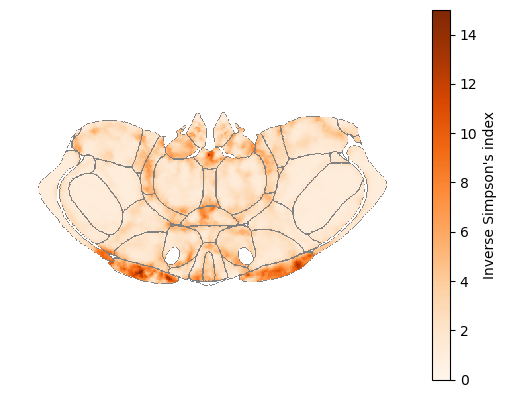

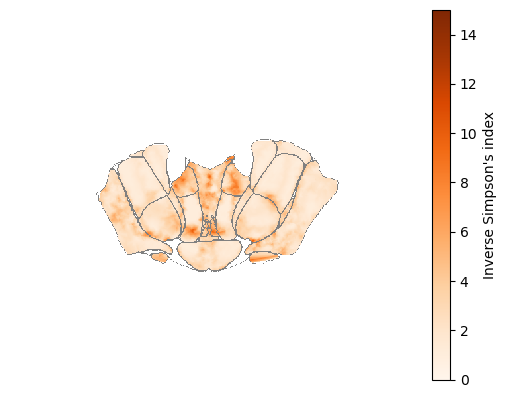

In [ ]:
section = 7.2

th_indices = [i for i, name in ccf_index.items() if name in th_structure_names]
def plot_section(section):
    obs = obs_neurons_ccf.join(cellwise_metrics).loc[lambda df: df[section_col]==section]
    interp = LinearNDInterpolator(obs[['x_'+coords, 'y_'+coords]], obs['local_isi_cluster']
                                #   /n_neighbors)
    )
    img = interp(*grid)
    fig, ax = plt.subplots()
    resolution = 10e-3
    extent = resolution * (np.array([0, imdata.shape[0], imdata.shape[1], 0]) - 0.5)

    sec_img = ccf_images[:,:,int(np.rint(section/200e-3))]
    mask = np.any(np.stack([sec_img==i for i in th_indices]), axis=0)
    img[~mask] = np.nan
    # img = gaussian_filter(img, 2)

    im = ax.imshow(img.T, cmap='Oranges', extent=extent, interpolation="none", vmin=0, vmax=15)

    cplot.plot_ccf_section(ccf_images, section,
                                        ccf_region_names=None, palette='dark_outline', ax=ax)
    cplot.format_image_axes()
    plt.colorbar(im, label="Inverse Simpson's index")


plot_section(7.2)
# plt.title("Local cluster diversity")
plt.savefig("/results/lisi_sec1.pdf", transparent=True)
plot_section(8.0)
plt.savefig("/results/lisi_sec2.pdf", transparent=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


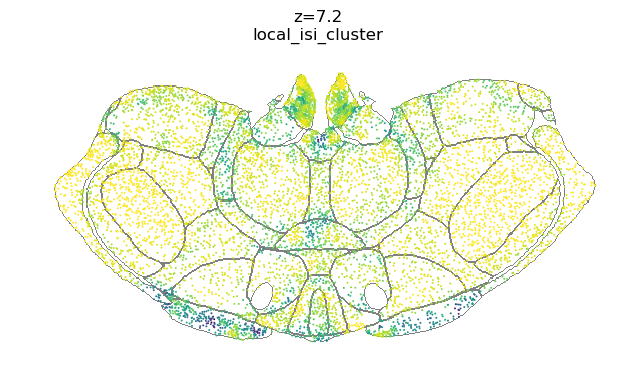

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


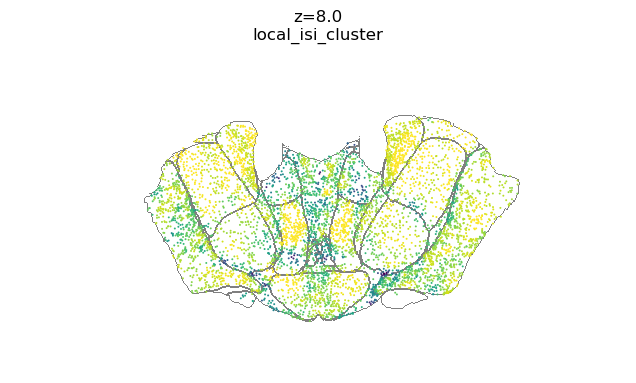

In [ ]:
obs = obs_neurons_ccf.join(cellwise_metrics)
kwargs = dict(
    section_col=section_col,
    x_col = 'x_'+coords,
    y_col = 'y_'+coords,
    s=2, 
    face_palette=None,
    edge_color='grey',
    # boundary_img=ccf_boundaries
)
figs = cplot.plot_ccf_overlay(obs, ccf_images, point_hue='local_isi_cluster', point_palette='viridis_r', 
                       categorical=False, legend=False, sections=[7.2, 8.0], **kwargs)
for i, fig in enumerate(figs):
    fig.savefig(f"/results/local_isi_sec{i}.pdf")

In [ ]:
# local index - about 2 min to run!

# n_neighbors = 15
# neighbors = neigh.kneighbors(X, n_neighbors=n_neighbors, return_distance=False)
# neighbors_series = pd.Series(neighbors.tolist(), index=obs_neurons_ccf.index)

# def local_metric(label_series, neighbors_series, function):
#     results = np.array([
#         function(
#     # doesn't include neighbors across boundaries...
#             # label_series.reindex(obs_neurons_ccf.index[ind]).dropna()
#             # label_series[label_series.index.intersection(obs_neurons_ccf.index[ind])]
#             obs_neurons_ccf[label_series.name].iloc[ind]
#             )
#         for ind in neighbors_series[label_series.index]
#         ])
#     return np.median(results)

# lisi = lambda x: local_metric(x, neighbors_series, inverse_simpsons)
# th_lisi = get_region_metric(obs_neurons_ccf, ccf_label, lisi, "lisi", levels=['cluster','supertype','subclass'])

In [ ]:
median_local_metrics = cellwise_metrics.join(obs_neurons_ccf[ccf_label]).groupby(ccf_label, observed=True).median().drop(
    index=['unassigned', 'TH-unassigned'])

7.2


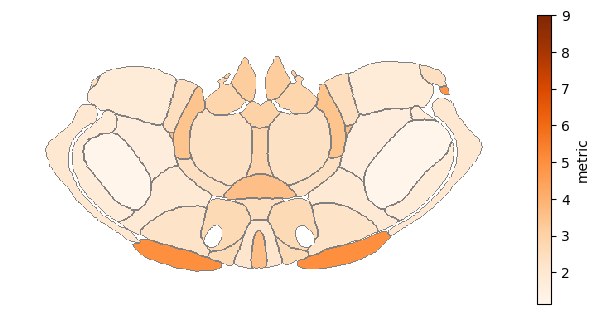

In [ ]:
cplot.plot_metrics_ccf(imdata, median_local_metrics["local_isi_cluster"], sections, ccf_index,
                       cmap='Oranges')

7.2


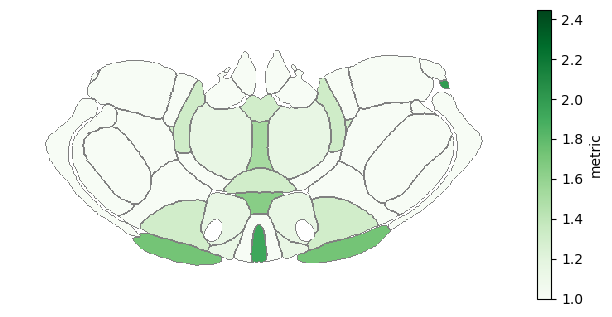

In [ ]:
cplot.plot_metrics_ccf(imdata, median_local_metrics["local_isi_subclass"], sections, ccf_index,
                       cmap='Greens')


## Proportions as stacked bar graphs

In [1]:
# for each subregion, count the proportion of cells in each cluster/supertype/subclass
regions = list(regions_to_plot)
ccf_cluster_counts = pd.DataFrame(0.0, index=regions, columns=th_clusters)
ccf_supertype_counts = pd.DataFrame(0.0, index=regions, columns=th_supertypes)
ccf_subclass_counts = pd.DataFrame(0.0, index=regions, columns=th_subclasses)
min_count = 5
for subregion, df in obs_neurons_ccf.groupby(ccf_label, observed=True):
    if subregion in regions_100:
        # clusters
        cluster_counts = df['cluster'].value_counts().loc[lambda x: x>min_count]
        ccf_cluster_counts.loc[subregion, 
                            cluster_counts.index] = cluster_counts.values / len(df)
        ccf_cluster_counts.loc[subregion, 'other'] = 1-ccf_cluster_counts.loc[subregion].sum()

        # supertypes
        supertype_counts = df['supertype'].value_counts().loc[lambda x: x>min_count]
        ccf_supertype_counts.loc[subregion, 
                                supertype_counts.index] = supertype_counts.values / len(df)
        ccf_supertype_counts.loc[subregion, 'other'] = 1-ccf_supertype_counts.loc[subregion].sum()

        # subclasses
        subclass_counts = df['subclass'].value_counts().loc[lambda x: x>min_count]
        ccf_subclass_counts.loc[subregion, 
                                subclass_counts.index] = subclass_counts.values / len(df)
        ccf_subclass_counts.loc[subregion, 'other'] = 1-ccf_subclass_counts.loc[subregion].sum()

NameError: name 'regions_to_plot' is not defined

In [ ]:
ccf_cluster_counts

#### TODO: Implement barchart w/ plotly

which will enable hovering over the bars to display the subclass/supertype/cluster to which it belongs

In [ ]:
# display as a stacked bar graph
from colorcet import glasbey_light

def plot_stacked_barplot(df, taxonomy_level, legend=True, palette=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    if palette is None:
        palette = abc.get_taxonomy_palette(taxonomy_level)
        # palette = sns.color_palette(glasbey_light, n_colors=len(df.columns))
    palette['other'] = 'grey'
    df.plot(kind='bar', stacked=True, ax=axes, legend=legend, color=palette)
    if legend:
        axes.legend(loc='upper left', bbox_to_anchor=(0.05, -0.3), ncol=4)
    axes.set_xticklabels(df.index, rotation=90)
    axes.set_xlabel('CCF structure')
    # axes.set_yticks([])
    axes.set_ylabel('proportion of cells in unique '+taxonomy_level)

    fig.subplots_adjust(hspace=0.1)
    
    # add text
    for i, subregion in enumerate(df.index):
        n_nonzero = (df.loc[subregion, df.columns!='other']>0).sum()
        axes.text(i, 1.01, n_nonzero, horizontalalignment='center')

#### Subclasses

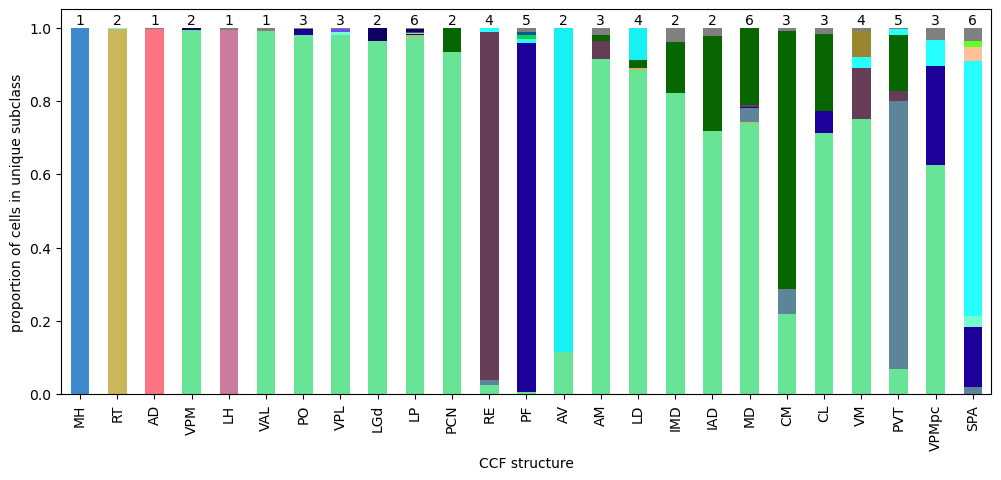

In [ ]:
# First sort by the Shannon Diversity Index from th_ccf_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_to_plot].sort_values(by='shannon_index_subclass', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_subclass_counts.loc[list(th_metrics_sorted_by_sdi.index)], 
                     'subclass', legend=False)

#### Supertypes

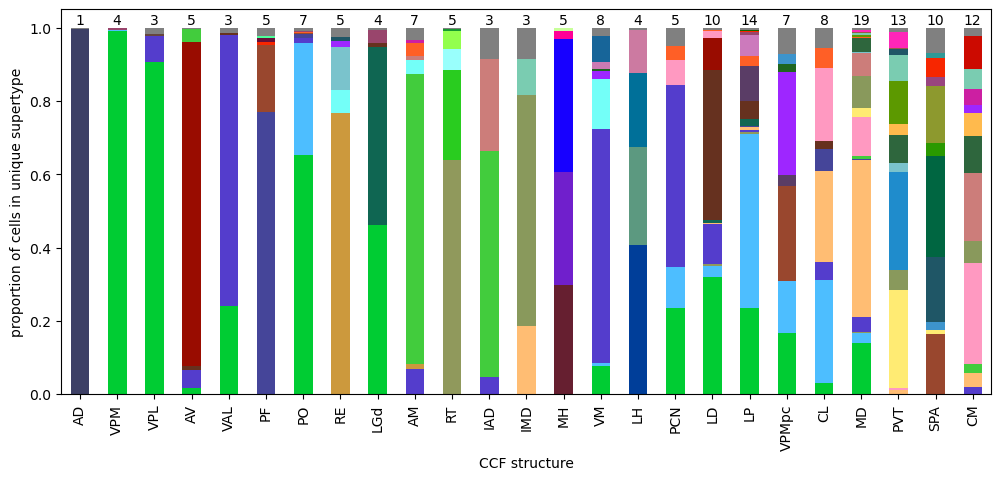

In [ ]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_subset].sort_values(by='shannon_index_supertype', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_supertype_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'supertype', legend=False)

#### Clusters

In [ ]:
cluster_palette_glasbey = pd.read_csv("resources/cluster_palette_glasbey.csv", index_col=0).iloc[:,0].to_dict()


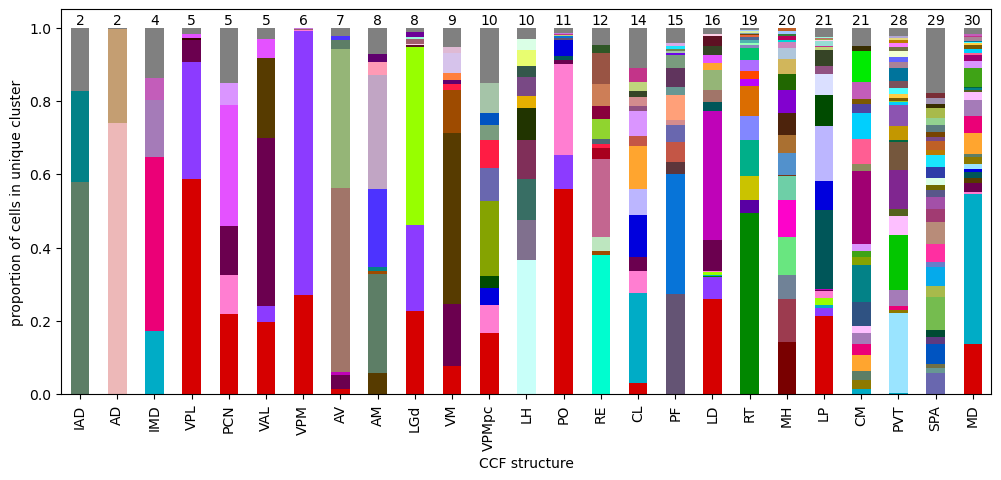

In [ ]:
# First sort by the Shannon Diversity Index from th_metrics
th_metrics_sorted_by_sdi = th_metrics.loc[regions_subset].sort_values(by='count_gt5_cluster', ascending=True)

# Use sorted list of subregions to plot in order from least diverse to most diverse
plot_stacked_barplot(ccf_cluster_counts.loc[th_metrics_sorted_by_sdi.index], 
                     'cluster', palette=cluster_palette_glasbey, legend=False)

plt.savefig("/results/nuclei_cluster_proportion_barplot.pdf", transparent=True)

# Per Cluster/Supertype/Subclass Metrics (neurons only)

## TODO: Dispersion of clusters/supertypes across nuclei

i.e. grab a cluster that dominates in one nucleus (e.g. 1133 in MD) and ask how dispersed it is across the whole thalamus. Ideally, a linear metric, such that you could ask what the dispersion is for all clusters to see which ones seem to be more compact and which are more shared

I *think* this is going to have to be done on hemispheres, rather than the whole brain. Most existing tools I'm finding are not able to account for symmetries.

Likely going to borrow from some of ArcGIS's standard toolboxes
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/h-how-standard-distance-spatial-statistic-works.htm

Or other satellite imagery methods:
- https://www.tandfonline.com/doi/full/10.1080/17538947.2018.1474957

# Neighborhood metrics

Single neuron tracing in the MD (shown in weekly U19 on Fri 7/28/23) illustrates two things:
1. Some *neighboring* soma have *distinct* projection patterns
2. Some *distant* soma have *very similar* projection patterns

Jayaram's interpretation is that \#1 is surprising given gene expression in the MD.

But I don't think that's the correct interpretation, especially in the MD! 
- MD contains a large diversity of cell types, many of which show salt-and-pepper sprinkling throughout the MD.
- At the very least, we don't have our MERFISH data analyzed in the right way to say whether or not the single neuron data is surprising/unexpected
- They really need their mFISH data to say this for certain

## TODO: most likely/common neighboring cell type metric

"most common / most likely neighbor" metrics for cells
- How likely are you to find a cell with (a) the same or (b) a different transcriptomic type right next to your cell of interest?
- What's the average fraction of nearest neighbors that are the same? different?
- How many non-self cell types are represented in the nearest neighbors?
- Do these metrics change from nucleus to nucleus? i.e. do cells in the MD have more diverse neighbors than, say, AD? (shannon index might suggest that they do)